In [19]:

from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd 

# Data Loading
data = pd.read_csv("D:\Skin Cancer Prediction\DATASET\hmnist_28_28_RGB.csv")
data.head()
meta_df = pd.read_csv("D:\Skin Cancer Prediction\DATASET\HAM10000_metadata.csv")
meta_df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [20]:
import tensorflow as tf

# Check for available GPUs
physical_devices = tf.config.list_physical_devices('GPU')

# If GPUs are available, configure session to use them
if len(physical_devices) > 0:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
  logical_devices = tf.config.list_logical_devices('GPU')

  print(logical_devices)

In [21]:
meta_df.shape
data.shape



(10015, 2353)

In [22]:
yData = data['label']
XData = data.drop(columns = ['label'])
# EDA
distribution = meta_df['dx'].value_counts()
distribution
# classes = {4: ('nv', ' melanocytic nevi'),
#            6: ('mel', 'melanoma'),
#            2 :('bkl', 'benign keratosis-like lesions'), 
#            1:('bcc' , ' basal cell carcinoma'),
#            5: ('vasc', ' pyogenic granulomas and hemorrhage'),
#            0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
#            3: ('df', 'dermatofibroma')}

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

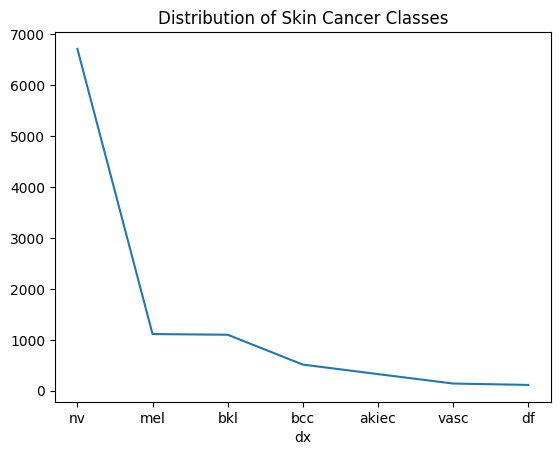

In [23]:
dist = data['label'].value_counts()
dist
distribution.plot()
plt.title('Distribution of Skin Cancer Classes')
plt.show()

In [24]:
# Fixing Data Imbalance

from imblearn.over_sampling import RandomOverSampler 
sampler = RandomOverSampler()
XData,yData  = sampler.fit_resample(XData,yData)
XData.shape, yData.shape
XData = np.array(XData).reshape((-1, 28, 28, 3))
XData = XData / 255
XData.shape


(46935, 28, 28, 3)

In [25]:
# Create the train and validation set
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(XData,yData, test_size=0.2)
Xtrain.shape, Xtest.shape



((37548, 28, 28, 3), (9387, 28, 28, 3))

In [26]:
# Train the model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import tensorflow as tf

img_width, img_height = 28,28

input_shape = (img_width, img_height, 3)


In [27]:
model = Sequential()
model.add(Conv2D(32, (2, 2), input_shape=input_shape))
model.add(Activation('swish'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (2, 2)))
model.add(Activation('swish'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (2, 2)))
model.add(Activation('swish'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('swish'))
model.add(Dropout(0.5))
model.add(Dense(7))
model.add(Activation('softmax'))



In [28]:
model.compile(loss='sparse_categorical_crossentropy',
optimizer='nadam',
metrics=['accuracy'])

In [29]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='skin.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)



In [30]:


history = model.fit(Xtrain,
                    Ytrain,
                    epochs = 100,
                    validation_data = (Xtest, Ytest),
                    callbacks=[callback, early_stopping])

Epoch 1/100
1170/1174 [============================>.] - ETA: 0s - loss: 1.4090 - accuracy: 0.4415
Epoch 1: saving model to skin.h5
1174/1174 [==============================] - 16s 13ms/step - loss: 1.4084 - accuracy: 0.4418 - val_loss: 1.0992 - val_accuracy: 0.5825
Epoch 2/100
1172/1174 [============================>.] - ETA: 0s - loss: 1.0530 - accuracy: 0.5966
Epoch 2: saving model to skin.h5
1174/1174 [==============================] - 17s 15ms/step - loss: 1.0529 - accuracy: 0.5966 - val_loss: 0.8939 - val_accuracy: 0.6448
Epoch 3/100
1171/1174 [============================>.] - ETA: 0s - loss: 0.8863 - accuracy: 0.6653
Epoch 3: saving model to skin.h5
1174/1174 [==============================] - 17s 14ms/step - loss: 0.8865 - accuracy: 0.6652 - val_loss: 0.7435 - val_accuracy: 0.7131
Epoch 4/100
1173/1174 [============================>.] - ETA: 0s - loss: 0.7678 - accuracy: 0.7110
Epoch 4: saving model to skin.h5
1174/1174 [==============================] - 15s 13ms/step - loss: 

In [31]:
import matplotlib.pyplot as plt
model.evaluate(Xtrain, Ytrain)
model.evaluate(Xtest, Ytest)



294/294 [==============================] - 2s 5ms/step - loss: 0.0765 - accuracy: 0.9787


[0.0765073299407959, 0.978693962097168]

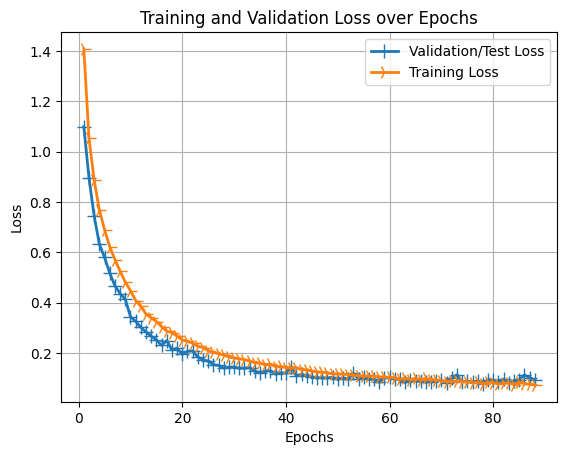

In [32]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.title('Training and Validation Loss over Epochs') 
plt.grid(True) 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



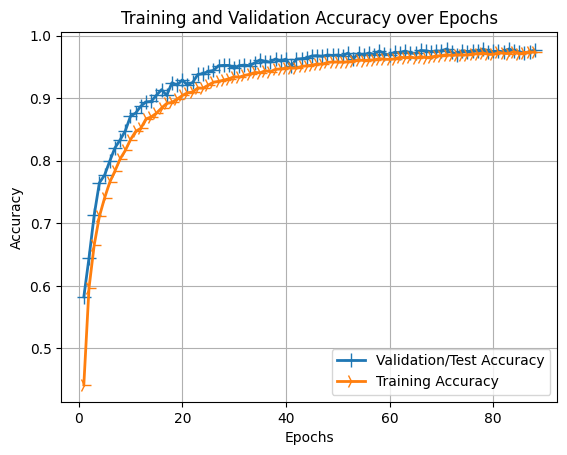

In [33]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [34]:
# Generate predicted probabilities for the test set
from sklearn.metrics import classification_report


y_pred_prob_test = model.predict(Xtest)
# Convert probabilities to class labels
y_pred_test = np.argmax(y_pred_prob_test, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(Ytest, y_pred_test))


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
294/294 [==============================] - 1s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1373
           1       0.99      1.00      0.99      1364
           2       0.96      0.99      0.97      1360
           3       

294/294 [==============================] - 2s 5ms/step


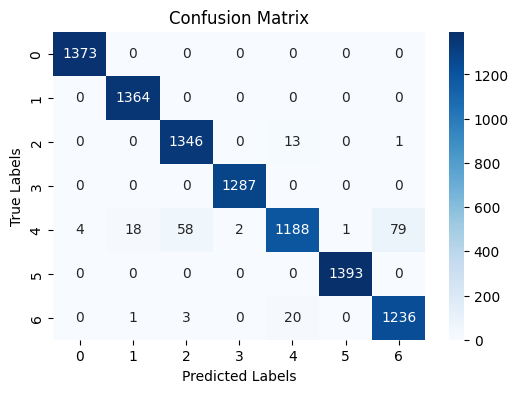

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predicted probabilities for the test set
y_pred_prob_test = model.predict(Xtest)
# Convert probabilities to class labels
y_pred_test = np.argmax(y_pred_prob_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(Ytest, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


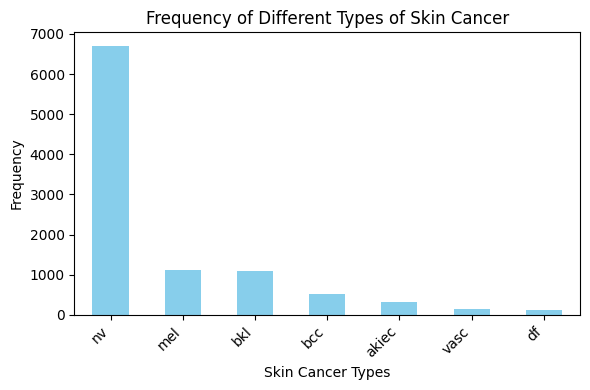

In [36]:

# Get the counts of different skin cancer types
skin_cancer_counts = meta_df['dx'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
skin_cancer_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Different Types of Skin Cancer')
plt.xlabel('Skin Cancer Types')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()
